# Using `musif` in pro mode

This tutorial is intended for people who already have some programming skills. If you just want to try and explore `musif`, first check the [Getting started tutorial](./Tutorial.html).
You will also find guide for installation procedure and set-up there.

In [ ]:
%pip install musif

First, let's import `musif`. You may need to restart the notebook kernel here!

In [2]:
import musif
print(musif.__version__)

1.2.2


## Data

To start, let's download a dataset which contains various pop-rock scores in MIDI format, from Eric Clapton to The Beatles. Just run the following cell:

In [3]:
import urllib.request
import zipfile
from pathlib import Path

data_dir = Path("data")
dataset_path = "dataset.zip"
urllib.request.urlretrieve("https://figshare.com/ndownloader/articles/5436031/versions/1", dataset_path)
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(data_dir)

Alternatively, you can download it from [here](https://figshare.com/ndownloader/articles/5436031/versions/1) from Zenodo. Uncompress it under a folder named `data` in the same directory as this notebook.

## Create pre-cache hooks

Since `musif` was created with a strong focus on 18th-century opera arias, there might be some elements in this dataset that are not fully supported by the parsing engine, or some aspect of the music that is not considered by the features.

First, let's focus on those notation elements that are not supported by our parsing engine. The best way to do this is by creating pre-cache hooks, i.e., pieces of code that are executed before the initialization of the cache system and, therefore, can alterate `music21` objects.

There are several ways to create these hooks. For more information refer to the [caching](./Caching.html) documentation page. Here, we'll create them using the class approach.

### Removing drums
Our pop-rock MIDI corpus contains one or more parts corresponding to drums or other percussion instruments.
Currently, `musif` is not able to handle such kind of notation and would throw errors about the score key signature.
For this reason, we are going to remove drum parts before starting the extraction.

Let's create a `RemoveDrums` class that finds every part that corresponds to a drum part and removes it from the data dictionary, so `musif` can extract the score peacefully.

In [5]:
# musif.extract.constants contains various constants useful to access the `data` dictionary
import musif.extract.constants as C

# the following list is specific to this dataset
drums_list = ['drumset', 'tambourine', 'drum', 'concert snare drum', 'hi-hat', 'automobile brake drums']

# a hook is any object that contains a `execute(cfg, data)` method
class RemoveDrums:
    def execute(cfg, data):
        # let's get the list of parts
        parts = list(data[C.DATA_FILTERED_PARTS])
        # C.DATA_SCORE is a music21.stream.Score object
        drums = [i for i in data[C.DATA_SCORE].parts if i.partName.split(',')[0].lower() in drums_list]
        # remove all the drums from the score
        data[C.DATA_SCORE].remove(drums)
        # reset the list of parts in the dictionary
        data[C.DATA_FILTERED_PARTS] = tuple([p for p in parts if p not in drums])
        # return the data
        return data

### Renaming similar parts
`musif` differentiates between part features based on their name. For instance, if two parts have the name `Guitar`, it will merge all the notes in just one part. We decided to enforce this requirement by design.

For this reason, we must create a hook that renames all parts that have the same name in our internal data dictionary, so extraction will be run with names already altered.

In [6]:
class RenameSimilarParts:
    def execute(cfg, data):
        parts = list(data[C.DATA_FILTERED_PARTS])
        part_names = set()
        counter = 1
        for part in data[C.DATA_SCORE].parts:
            # If the part is already in part_names set, we must change its partName, Abbreviation and Id. For example when having two guitar parts.
            if part.partName in part_names:
                part.partName = part.partName + f'({counter})'
                part.partAbbreviation = part.partAbbreviation + f'({counter})'
                part.id = part.id + int(f'{counter}')
                counter += 1
                part_names.add(part.partName)
            else:
                part_names.add(part.partName)
        # By altering the part object of music21, the change its already reflected also in the parts list.       
        data[C.DATA_FILTERED_PARTS] = tuple(parts)
        return data

## Create your own custom feature

Now, we are going to create a custom feature. Methods to create custom features are detailed in the [custom features](./Custom_features.html) documentation page. Briefly, there are two main ways to do it:

- As a module: like the stock `musif` features. If you have `musif` installed you can just copy one of the modules and adapt it to your taste, for instance [`musif.extract.features.ambitus`](https://github.com/DIDONEproject/musif/tree/main/musif/extract/features/ambitus) could be a good starting point.
- As a class: We need to create a class that contains a `handler` sub-class that will run our calculations. This is the method we are going to show now, as it is more suitable for small modules and for a Jupyter notebook.

First, let's create a class. In our case, we will create a dummy feature that calculates the number of beats for which the vocal part is in silence over the total of beats of the song. Note that `musif` is actually already computing the opposite, i.e., the ratio of measures in which the vocal part is singing.

For the purpose of the tutorial, we also show how the file name of a music score can be used to retrieve information, e.g., metadata.

Firts, let's import some `musif` utilities:

In [7]:
from ntpath import basename
from musif.musicxml.tempo import get_number_of_beats
import musif.extract.constants as C
from musif.extract.features.core.constants import DATA_NOTES_AND_RESTS, DATA_MEASURES
from musif.extract.features.tempo.constants import TIME_SIGNATURE
from musif.extract.features.prefix import get_part_feature

Considering a `musif` stock feature like `ambitus`, `musif.extract.features` is the feature package while `musif.extract.features.ambitus` is a feature module.

Here, since we are working inside a Jupyter notebook, we will substitute the package containing the features with a  class named `custom_feature_package`, so that the hierarchy is `feature package > feature module > handler`. Inside the feature package there can be multiple features.

We will name our feature `voice_silence_beats` and `custom_file_name`. They will also be the feature module names. Each feature must contain an object called `handler`, which in turn must contain two methods: `update_part_objects` and `update_score_objects`.

In the case of our custom feature, `custom_feature_package`, `voice_silence_beats`, `custom_file_name`, and `handler` are all classes, but they could also be packages and modules.

Since we want that `custom_file_name` is computed only once for each window, we implement is inside a different feature package, namely the class `custom_basic_module`. However, it could be implemented inside `custom_feature_package` as well.

In [8]:
VOICE_SILENCE_BEATS = 'voice_silence_beats'

class custom_feature_package:
    class voice_silence_beats:
        """
        This feature calculates the number of beats the voice is in silence over the total of the song
        """
        class handler:
            def update_part_objects(
                score_data: dict = None,
                part_data: list = None,
                cfg: object = None,
                parts_features: list = None,
            ):
                # We will extract the number of beats that voice parts are in silence and 
                # divide it by the total number of beats. First we need to filter only voice/singer parts. 
                if part_data[C.DATA_FAMILY] == 'voice':
                    rests = [i for i in part_data[DATA_NOTES_AND_RESTS] if i.isRest]
                    rests_duration = sum([i.quarterLength for i in rests])
                    number_of_measures = score_data[DATA_MEASURES]
                    total_beats = get_number_of_beats(score_data[TIME_SIGNATURE]) * number_of_measures
                    voice_silence = rests_duration / total_beats if total_beats else 0
                    parts_features[get_part_feature(part_data[C.DATA_PART_ABBREVIATION], VOICE_SILENCE_BEATS)] = voice_silence
                else:
                    pass
            def update_score_objects(
                score_data: dict = None,
                parts_data: list = None,
                cfg: object = None,
                parts_features: list = None,
                score_features: dict = None,
            ):
                # Finally, we need to add the data to score_features, 
                # the dictionary where all final info is stored. 
                # Otherwise it will not be reflected in the final dataframe.
                features = {}
                for i, part_data in enumerate(parts_data):
                    if part_data[C.DATA_FAMILY] == 'voice':
                        part_abbreviation = part_data[C.DATA_PART_ABBREVIATION]
                        feature_name = get_part_feature(part_abbreviation, VOICE_SILENCE_BEATS)
                        features[feature_name]=parts_features[i][get_part_feature(part_abbreviation, VOICE_SILENCE_BEATS)]
                score_features.update(features)

class custom_basic_module:
    class custom_file_name:
        "Set up artist and title from the file name"
        class handler:
            def update_score_objects(
                score_data,
                parts_data,
                cfg,
                parts_features,
                score_features
            ):
                chunks = basename(score_data[C.DATA_FILE]).split('.')
                artist = chunks[0]
                title = chunks[-1]

                score_features.update(
                    {
                        'Artist': artist,
                        'Title': title,
                    }
                )

            def update_part_objects(
                score_data, part_data, cfg, part_features
            ):
                pass

## Configuration

Let's create a configuration for our experiment. For more information, see the [Getting started tutorial](./Tutorial.html).

Here, we will point your attention towards the following options:
1. `features`: We added `voice_silence_beats`, our custom feature.
2. `feature_module_addresses` and `basic_modules_addresses`: We added `custom_feature_package` and `custom_basic_module`.
3. `precache_hooks`: We added our hooks `RemoveDrums` and `RenameSimilarParts`, but it can also contain strings representing modules or packages that can be imported by Python, similarly to `feature_modules_addresses`.
4. `window_size` and `overlap`: We are extracting features at the window level, where each window is 8 measure long and the hop-size is 4 measures.

In [9]:
from musif.config import ExtractConfiguration

config = ExtractConfiguration(
    None,
    data_dir = "data_poprock",
    # We can pass our custom features as python variables or as a strings that is importable by __import__
    feature_modules_addresses=["musif.extract.features", custom_feature_package], 
    basic_modules_addresses=["musif.extract.basic_modules", custom_basic_module],
    # Now, we list the features that we want to extract 
    basic_modules = ['scoring', "custom_file_name"],
    features = ["core", "ambitus", "melody", "tempo"
                "density", "texture", "lyrics", "scale", 
                "key", "dynamics", "rhythm", 
                "voice_silence_beats"],
    # As for features, hooks can be expressed as variables or as strings that can imported by __import__
    precache_hooks = [RemoveDrums, RenameSimilarParts], 
    # window size is 8 measures with overlap of 50%
    window_size = 8, 
    overlap = 4,
    # Important! This parameter allows to extract all files skipping those that
    # fail during extraction. If you encounter any eerors please report them andopen an issue on Github and we w'll take
    # a look as soon as possible!
    ignore_errors=True,
    # cache_dir='__tutorial_cache', #If cache use is desired
    parallel = -1 #Set number of cores. 1 for no parallel, -1 for all cores
)

## Feature extraction

Now that we have our configuration, we pass it to the `FeaturesExtractor` constructor:

In [10]:
from musif.extract.extract import FeaturesExtractor

extractor = FeaturesExtractor(config)

In [11]:
import musif.musescore.constants as musescore_c
musescore_c.MUSESCORE_FILE_EXTENSION = '.mid'

In [12]:
df = extractor.extract()

100%|██████████| 25/25 [00:00<00:00, 199.16it/s]


AttributeError: 'ExtractConfiguration' object has no attribute 'output_dir'

Since we extracted features at the window level, the dataset has now a multi-index: The first index indicates the music score, while the second index indicates the window in the score:

In [12]:
# To show the DataFrame in a Jupyter notebook, just use it as last instruction of the cell, like this:
df.shape

(467, 49623)

## Post-processing

We will now postprocess the data, again, see the [Getting started tutorial](./Tutorial.html) for more info.

In [13]:
from musif.process.processor import DataProcessor

processed_df = DataProcessor(df,'../../config_postprocess_example.yml').process().data

# with `.shape` you can see the number of rows and columns of the DataFrame.
processed_df.shape


Post-processing data...


(467, 162)

As you see, the columns are now less than before!

Let's try to remove `NaN` (elements that should be number but that cannot be expressed, e.g., the division $0/0$). To do this, we'll use the [`dropna` method](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html?highlight=dropna#pandas.DataFrame.dropna) of the `pandas.DataFrame` object.

In [14]:
processed_df.dropna(axis=1, inplace=True)
processed_df.shape

(467, 162)

## Visualization

We will now visualize the 610 windows contained in the dataset using Linear Discriminant Analysis (LDA). Note that LDA is a supervised method, so a leave-one-out cross-validation would be needed to properly monitor overfitting. However, for the purpose of this tutorial, we will limit to showcase an overfitted model.

For this visualization, you will need to install `scikit-learn` and `seaborn`. After installing them, remember to restart the kernel of the notebook!

In [15]:
%pip install scikit-learn seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


<AxesSubplot: >

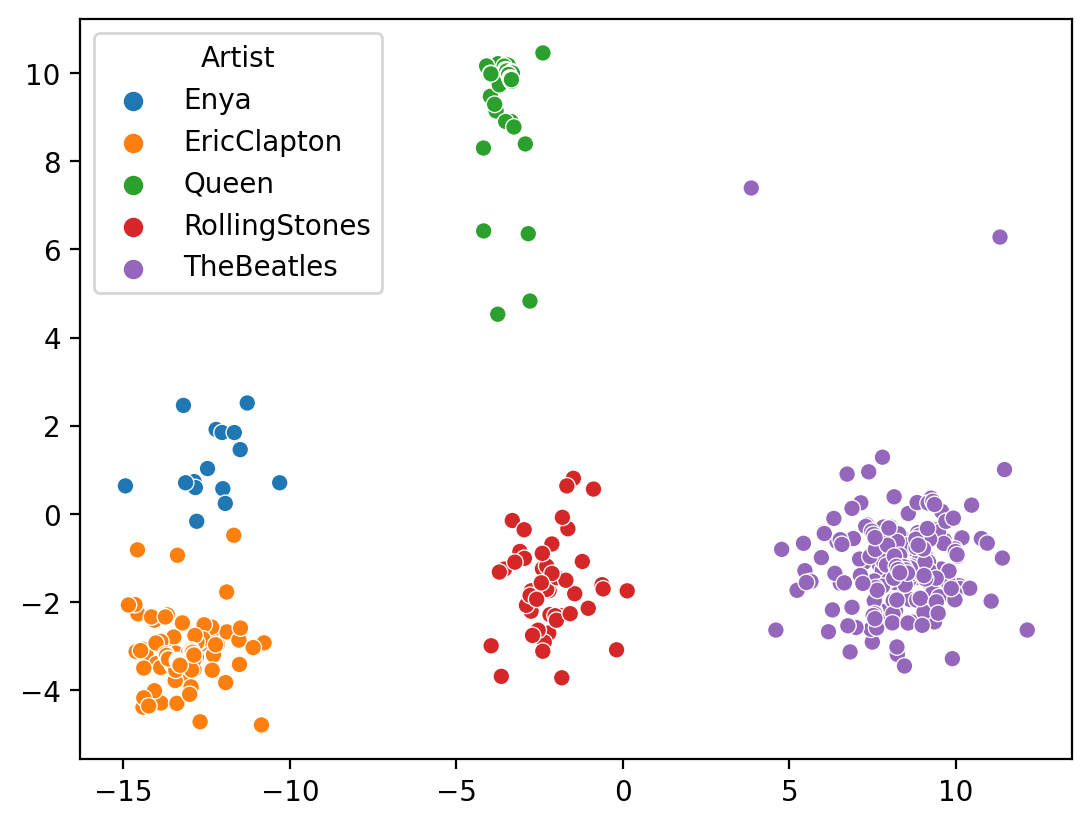

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
import seaborn as sns

target = processed_df['Artist']
data = processed_df.drop(columns=['Id', 'WindowId']).select_dtypes([int, float])
data = make_pipeline(StandardScaler(), 
                     VarianceThreshold(0.25),
                     LDA(n_components=2, solver='svd')).fit_transform(data, target)
sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=target)

Beatles, Rolling Stone, and Eric Clapton are rather similar, apparently. Taking some simple statistics of the windows, such as the mean, doesn't help:

(467, 2)


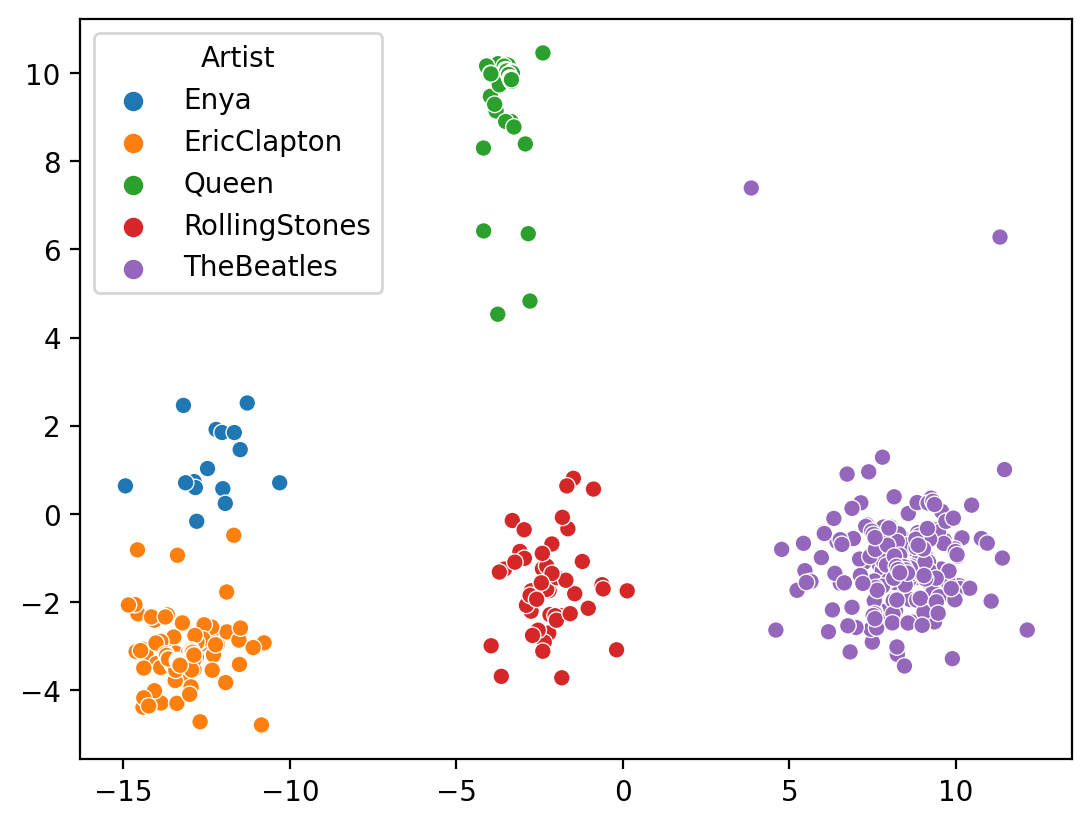

In [22]:
target = processed_df['Artist'].groupby(level=0).nth(0) # 'Artist' of each window number 0
data = processed_df.drop(columns=['Id', 'WindowId']).select_dtypes([int, float])
data = data.groupby(level=0).mean() # taking the average of the features across the windows here!
data = make_pipeline(StandardScaler(),
                     VarianceThreshold(0.25),
                     LDA(n_components=2, solver='svd')).fit_transform(data, target)
sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=target)

Let's see if the development of the features across time can reveal something.

We will repeat the same process for creating the embedding, but we will insert a signal processing approach consisting in the computation of the Discrete Fourier Transformation (DFT). In this way, the LDA computes an embedding taking into account the development of the features across time.

Note that the size of the FFT may be increased when a larger dataset is used.

<AxesSubplot: >

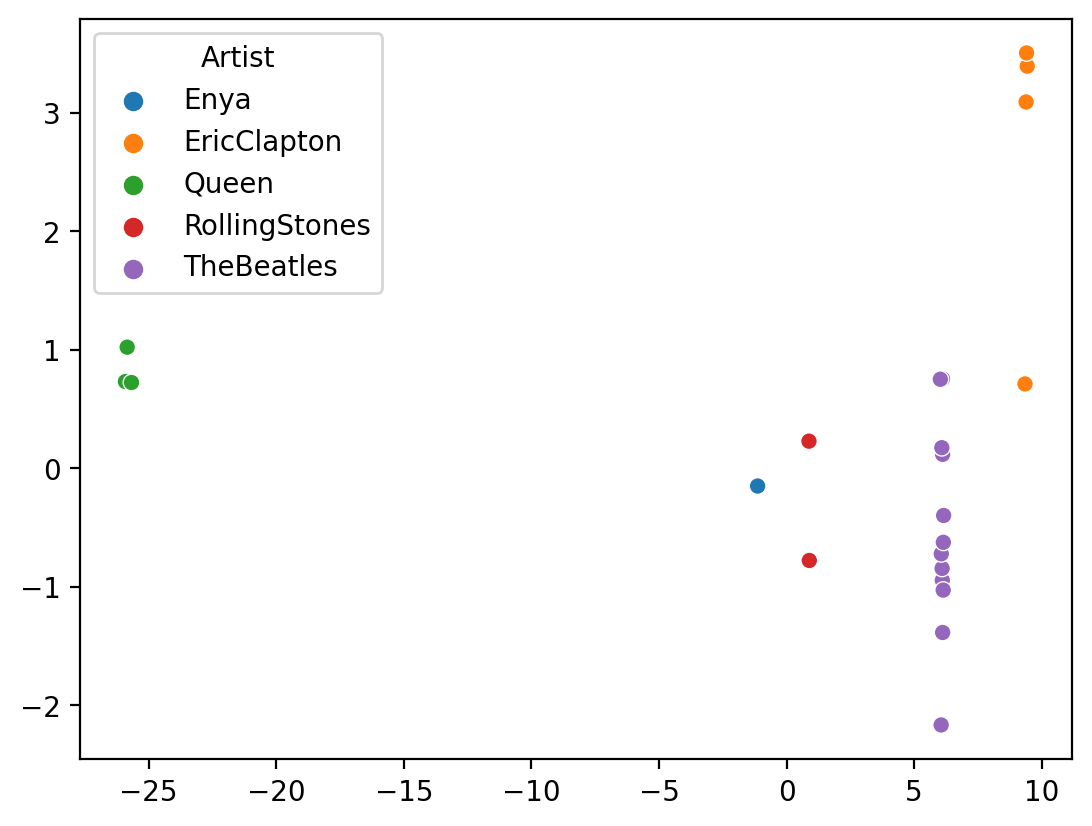

In [28]:
from scipy.fft import fft
from sklearn.preprocessing import FunctionTransformer
import pandas as pd
import numpy as np

# data selection
target = processed_df.set_index('Id').groupby(level=0).nth(0)['Artist']  # 'Artist' of each window number 0
score_groups = processed_df['Id'].to_numpy().astype(str) # groups of samples used for the DCT
data = processed_df.select_dtypes([float, int])          # features

# function to compute the FFT of a score
def compute_fft(x):
    groups = pd.DataFrame(x).groupby(score_groups)
    ret = groups.apply(lambda df: fft(df, n=8, axis=0).mean(axis=0))
    return np.absolute(np.stack(ret.to_list()))

# training model
model = make_pipeline(StandardScaler(), 
                      VarianceThreshold(0.2),
                      FunctionTransformer(compute_fft),
                      LDA(n_components=2, solver='svd'))
data = model.fit_transform(data, target)
sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=target, legend=True)

As we can see, development of the features across time sets a clear difference between differnet scores and composers. We can extract some conclusions out of this, like the composer stile along the piece has a significant role. 

This will be it! It's now your turn to use create your own features, pre-hooks and take the most potential out of `musif` to get interesing musicological results.

In case in any doubt or missfunction, please do not hesitate to open an issue or to reach us and we'll do oiur best to solve it. 

Enjoy!